In [39]:
import glob
import pandas as pd

In [40]:
from sklearn.model_selection import train_test_split

In [56]:
path = '../Downloads/CSVs/' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    print(file_)
    try:
        df = pd.read_csv(file_,index_col=None, header=0)
    except:
        df = pd.read_csv(file_,index_col=None, header=0, encoding = 'latin1')
    list_.append(df)
frame = pd.concat(list_)

../Downloads/CSVs/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv


/Users/ozalmanson/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


../Downloads/CSVs/Monday-WorkingHours.pcap_ISCX.csv


/Users/ozalmanson/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


../Downloads/CSVs/Friday-WorkingHours-Morning.pcap_ISCX.csv
../Downloads/CSVs/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
../Downloads/CSVs/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv


/Users/ozalmanson/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (20,21,85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


../Downloads/CSVs/Tuesday-WorkingHours.pcap_ISCX.csv
../Downloads/CSVs/Wednesday-workingHours.pcap_ISCX.csv
../Downloads/CSVs/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv


/Users/ozalmanson/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,1,3,6,20,21,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [57]:
import numpy as np

In [58]:
frame = frame.dropna(how = 'all')

In [59]:
frame[' Flow Packets/s'] = frame[' Flow Packets/s'].astype('float64')
frame['Flow Bytes/s'] = frame['Flow Bytes/s'].astype('float64')
frame = frame.drop(' Timestamp', axis = 1)
frame = frame.replace([np.inf, -np.inf], np.nan)

In [46]:
#frame = frame.merge(dest_ip_num, left_index = True, right_index = True)
#frame = frame.merge(src_ip_num, left_index = True, right_index = True)

In [61]:
non_trainable = ['Flow ID', ' Source IP', ' Destination IP', ' Timestamp', 'External IP', ' Label', 'dest_a','dest_b','dest_c','dest_d','src_a','src_b', 'src_c','src_d']

In [62]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [71]:
label_mapping = {val: i for i, val in enumerate(list(frame[' Label'].drop_duplicates()))}
y_all = frame[' Label'].replace(label_mapping)
y_all = y_all.as_matrix()

In [73]:
y_all = to_categorical(y_all)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(frame[[col for col in frame.columns if col != ' Label']], y_all, test_size=0.2, shuffle = False, random_state=42)

In [76]:
from sklearn.preprocessing import StandardScaler

In [77]:
scaler = StandardScaler()

In [78]:
scaled_train_X = scaler.fit_transform(X_train[[column for column in X_train.columns if column not in non_trainable]].fillna(0))

In [79]:
scaled_test_X = scaler.transform(X_test[[column for column in X_test.columns if column not in non_trainable]].fillna(0))

In [81]:
y_test.shape

(566149, 15)

In [82]:
scaled_train_X = scaled_train_X.reshape((scaled_train_X.shape[0], 1, scaled_train_X.shape[1]))
scaled_test_X = scaled_test_X.reshape((scaled_test_X.shape[0], 1, scaled_test_X.shape[1]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                37120     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                495       
Total params: 39,695
Trainable params: 39,695
Non-trainable params: 0
_________________________________________________________________
None
Train on 2264594 samples, validate on 566149 samples
Epoch 1/10
 - 95s - loss: 3.1068 - val_loss: 1.0104
Epoch 2/10
 - 110s - loss: 3.1028 - val_loss: 1.0104
Epoch 3/10
 - 100s - loss: 3.1028 - val_loss: 1.0104
Epoch 4/10
 - 96s - loss: 3.1028 - val_loss: 1.0104
Epoch 5/10
 - 104s - loss: 3.1028 - val_loss: 1.0104
Epoch 6/10
 - 101s - loss: 3.1028 - val_loss: 1.0104
Epoch 7/10
 - 109s - loss: 3

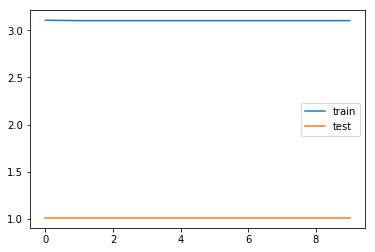

In [85]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from matplotlib import pyplot
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(scaled_train_X.shape[1], scaled_train_X.shape[2])))
model.add(Dense(32, activation = 'relu'))
#model.add(Dense(32, activation = 'relu'))
model.add(Dense(y_train.shape[1],  activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
print(model.summary())
# fit network
history = model.fit(scaled_train_X, y_train, epochs=10, batch_size=72, validation_data=(scaled_test_X, y_test), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [86]:
pred = model.predict(scaled_test_X)

In [87]:
from sklearn.metrics import classification_report

In [99]:
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(pred, axis =1)))

             precision    recall  f1-score   support

          0       0.94      1.00      0.97    530659
          9       0.00      0.00      0.00     23006
         10       0.00      0.00      0.00     10293
         11       0.00      0.00      0.00        11
         12       0.00      0.00      0.00      1507
         13       0.00      0.00      0.00       652
         14       0.00      0.00      0.00        21

avg / total       0.88      0.94      0.91    566149



/Users/ozalmanson/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [100]:
from sklearn.metrics import confusion_matrix

In [102]:
print(confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(pred, axis =1)))

[[530659      0      0      0      0      0      0]
 [ 23006      0      0      0      0      0      0]
 [ 10293      0      0      0      0      0      0]
 [    11      0      0      0      0      0      0]
 [  1507      0      0      0      0      0      0]
 [   652      0      0      0      0      0      0]
 [    21      0      0      0      0      0      0]]


In [108]:
sum([1 for val in np.argmax(y_train, axis = 1) if val == 0])

1828630

In [109]:
y_train_binary = np.argmax(y_train, axis = 1) 
y_test_binary = np.argmax(y_test, axis = 1) 

In [113]:
y_train_binary = list(map(lambda val: 1 if val > 0 else 0,y_train_binary))
y_test_binary = list(map(lambda val: 1 if val > 0 else 0,y_test_binary))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                37120     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 39,233
Trainable params: 39,233
Non-trainable params: 0
_________________________________________________________________
None
Train on 2264594 samples, validate on 566149 samples
Epoch 1/10
 - 93s - loss: 0.2740 - val_loss: 0.2289
Epoch 2/10
 - 94s - loss: 0.0223 - val_loss: 0.1713
Epoch 3/10
 - 92s - loss: 0.0185 - val_loss: 0.1742
Epoch 4/10
 - 95s - loss: 0.0167 - val_loss: 0.1568
Epoch 5/10
 - 89s - loss: 0.0151 - val_loss: 0.1497
Epoch 6/10
 - 95s - loss: 0.0140 - val_loss: 0.1605
Epoch 7/10
 - 92s - loss: 0.0142

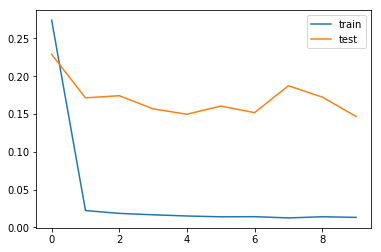

In [115]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from matplotlib import pyplot
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(scaled_train_X.shape[1], scaled_train_X.shape[2])))
model.add(Dense(32, activation = 'relu'))
#model.add(Dense(32, activation = 'relu'))
model.add(Dense(1,  activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
print(model.summary())
# fit network
history = model.fit(scaled_train_X, y_train_binary, epochs=10, batch_size=72, validation_data=(scaled_test_X, y_test_binary), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [116]:
pred = model.predict(scaled_test_X)

In [124]:
pred

array([[1.        ],
       [0.9999999 ],
       [1.        ],
       ...,
       [0.00431556],
       [0.01380701],
       [0.00103333]], dtype=float32)

In [123]:
print(classification_report(y_train_binary, list(map(lambda val: 1 if val > 0.5 else 0,pred))))

ValueError: Found input variables with inconsistent numbers of samples: [2264594, 566149]

In [121]:
y_train_binary

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
